# Find the most profitable arbitrage opportunity with QAOA
Given a market condition as a directed graph, find a closed cycle in the graph that represents the most profitable arbitrage opportunity. We solve this problem with Qiskit and the QAOA approach.

Here are some market conditions:

In [15]:
# No arbitrage opportunity
c_2_no_arbit = {
    ("EUR", "GBP"): 0.88,
    ("GBP", "EUR"): 1.13
}

# Arbitrage possible with just two assets
c_2_yes_arbit = {
    ("EUR", "GBP"): 0.88,
    ("GBP", "EUR"): 1.23
}

c_3_no_arbit = {
    ("EUR", "GBP"): 0.88,
    ("GBP", "EUR"): 1.13,
    ("EUR", "CAD"): 1.47,
    ("CAD", "EUR"): 0.68,
    ("GBP", "CAD"): 1.65,
    ("CAD", "GBP"): 0.6
}

# GBP -> EUR -> CAD -> GBP makes you money. The other cycles do not.
c_3_yes_arbit = {
    ("EUR", "GBP"): 0.88,
    ("GBP", "EUR"): 1.13,
    ("EUR", "CAD"): 1.58,
    ("CAD", "EUR"): 0.61,
    ("GBP", "CAD"): 1.65,
    ("CAD", "GBP"): 0.6
}


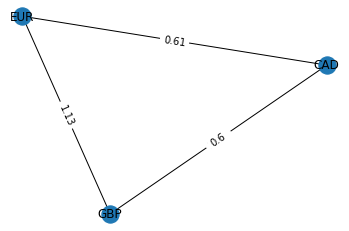

In [16]:
%matplotlib inline

import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

plot_this = c_3_yes_arbit

G.add_edges_from(list(plot_this.keys()))

pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=plot_this)
plt.axis('off')
plt.show()

Some useful functions:

In [17]:
import qiskit.aqua
qiskit.aqua.__version__

'0.6.0'

In [18]:
%load_ext autoreload
%autoreload 2

import numpy as np
from qiskit import BasicAer as Aer
from qiskit import QuantumRegister, execute
from qiskit.quantum_info import Pauli
from qiskit.aqua import Operator, get_aer_backend
from qiskit.aqua.components.initial_states import Custom
from scipy.optimize import minimize

def pauli_x(q, coeff, n):
    eye = np.eye((n)) # the i^th row of the identity matrix is 
                      # the correct parameter for \sigma_i 
    return Operator([[coeff, Pauli(np.zeros(n), eye[q])]])

def pauli_z(q, coeff, n):
    eye = np.eye((n))
    return Operator([[coeff, Pauli(eye[q], np.zeros(n))]])

def product_pauli_z(q1, q2, coeff, n):
    eye = np.eye((n))
    return Operator([[coeff, Pauli(eye[q1], np.zeros(n)) *
                      Pauli(eye[q2], np.zeros(n))]])

In [19]:
def evolve(hamiltonian, angle, quantum_registers):
    return hamiltonian.evolve(None, angle, 'circuit', 1,
                              quantum_registers=quantum_registers,
                              expansion_mode='suzuki',
                              expansion_order=3)

def create_circuit(beta, gamma, Hc, Hm, qr, circuit_init, n_qubits):
    identity = pauli_x(0, 0, n_qubits)
    p = len(gamma)
    circuit_evolv = sum([evolve(Hc, beta[i], qr) + evolve(Hm, gamma[i], qr)
                            for i in range(p)], evolve(identity, 0, qr))
    print("create: ", circuit_evolv.n_qubits)
    circuit = circuit_init + circuit_evolv
    print("create2: ", circuit_init.n_qubits, circuit.n_qubits)
    return circuit

def evaluate_circuit(beta, gamma, Hc, Hm, qr, circuit_init, n_qubits):
    circuit = create_circuit(beta, gamma, Hc, Hm, qr, circuit_init, n_qubits)
    print(circuit.n_qubits)
    return np.real(Hc.eval("matrix", circuit,
                   get_aer_backend('statevector_simulator'))[0])

The market condition is represented as a cost Hamiltonian:

In [20]:
def get_cost_hamiltonian(rates, m1, m2): # ordered dict
    n = len(rates)
    assets = set(k for k, v in rates.keys())
    operators = []
    for i, r in enumerate(rates.values()):
        operators.append(pauli_z(i, -np.log(r), n))
    for a in assets:
        for i, k in enumerate(rates.keys()):
            print(k)
            x1, y1 = k
            if x1 != a: continue
            for j, (x2, y2) in enumerate(rates.keys()):
                if x2 != a: continue
                operators.append(product_pauli_z(i, j, m1, n))
            for j, (x2, y2) in enumerate(rates.keys()):
                if y2 != a: continue
                operators.append(product_pauli_z(i, j, -2 * m1, n))
        for i, (x1, y1) in enumerate(rates.keys()):
            if y1 != a: continue
            for j, (x2, y2) in enumerate(rates.keys()):
                if y2 != a: continue
                operators.append(product_pauli_z(i, j, m1, n))
    # for a in assets:
    #     for i, (x1, y1) in enumerate(rates.keys()):
    #         if x1 != a: continue
    #         operators.append(pauli_z(i, m2, n))
    #         for j, (x2, y2) in enumerate(rates.keys()):
    #             if x2 != a: continue
    #             operators.append(product_pauli_z(i, j, -m2, n))
    identity = pauli_x(0, 0, n)
    Hc = sum(operators, identity)
    Hc.to_matrix()
    return Hc

In [21]:
def get_mixing_hamiltonian(n):
    identity = pauli_x(0, 0, n)

    Hm = sum([pauli_x(i, -1, n) for i in range(n)], identity)
    Hm.to_matrix()
    return Hm

Actually running the whole thing:

In [22]:
rates = c_3_no_arbit
n_iter = 5 # number of iterations of the optimization procedure
p = 1
beta = np.random.uniform(0, np.pi*2, p)
gamma = np.random.uniform(0, np.pi*2, p)
n = len(rates)
init_state_vect = [1 for i in range(2 ** n)]
init_state = Custom(n, state_vector=init_state_vect)
qr = QuantumRegister(n)
circuit_init = init_state.construct_circuit('circuit')
qr = circuit_init.qregs[0]
Hc = get_cost_hamiltonian(rates, 1, 1)
Hm = get_mixing_hamiltonian(n)
print(Hc)
result = minimize(lambda x: evaluate_circuit(x[:p],
                                             x[p:],
                                             Hc, Hm, qr, circuit_init, n),
                  np.concatenate([beta, gamma]),
                  method='L-BFGS-B')

circuit = create_circuit(result['x'][:p], result['x'][p:], Hc, Hm, qr,
                         circuit_init, n)

backend = Aer.get_backend('statevector_simulator')
job = execute(circuit, backend)
state = np.asarray(job.result().get_statevector(circuit))


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (local_num_qubits - 2)))
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/extensions/quantum_initializer/initializer.py:215: DeprecationWarning: scipy.kron is deprecated and will be removed in SciPy 2.0.0, use numpy.kron instead
  np.identity(2 ** (

/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:267: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/pyt

('EUR', 'GBP')
('GBP', 'EUR')
('EUR', 'CAD')
('CAD', 'EUR')
('GBP', 'CAD')
('CAD', 'GBP')
('EUR', 'GBP')
('GBP', 'EUR')
('EUR', 'CAD')
('CAD', 'EUR')
('GBP', 'CAD')
('CAD', 'GBP')
('EUR', 'GBP')
('GBP', 'EUR')
('EUR', 'CAD')
('CAD', 'EUR')
('GBP', 'CAD')
('CAD', 'GBP')
Representation: matrix, qubits: 6, size: 64x64


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:1339: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:1550: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:1303: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6
6


/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/q_env/lib/py

create:  6
create2:  6 6


In [13]:
print(np.absolute(state))

[0.11462757 0.19754519 0.16840119 0.11572339 0.04834766 0.13409692
 0.03347702 0.04803631 0.10898179 0.22228416 0.16254933 0.11041189
 0.11115844 0.19651684 0.16238115 0.11219758 0.03524425 0.05449839
 0.12044284 0.03607785 0.06768476 0.11321102 0.08494996 0.06852017
 0.09869282 0.1657525  0.13439807 0.09962586 0.03806458 0.05954235
 0.11858331 0.03893616 0.14598045 0.15811314 0.16423961 0.14649975
 0.13354655 0.10077179 0.11158126 0.13331062 0.0237379  0.07409263
 0.06517142 0.02379069 0.14169561 0.15495775 0.15991688 0.14220471
 0.11348947 0.19581043 0.16830609 0.11458781 0.04862002 0.13377813
 0.03461467 0.04833202 0.10805455 0.22064667 0.16157558 0.10947351
 0.11010173 0.19480345 0.16230452 0.11114394]


In [5]:
res = [0.11462757, 0.19754519 ,0.16840119, 0.11572339, 0.04834766, 0.13409692,
 0.03347702 ,0.04803631 ,0.10898179, 0.22228416 ,0.16254933, 0.11041189,
 0.11115844 ,0.19651684 ,0.16238115, 0.11219758, 0.03524425, 0.05449839,
 0.12044284 ,0.03607785 ,0.06768476, 0.11321102, 0.08494996, 0.06852017,
 0.09869282 ,0.1657525  ,0.13439807, 0.09962586, 0.03806458, 0.05954235,
 0.11858331, 0.03893616 ,0.14598045, 0.15811314 ,0.16423961, 0.14649975,
 0.13354655, 0.10077179, 0.11158126, 0.13331062, 0.0237379 , 0.07409263,
 0.06517142, 0.02379069, 0.14169561, 0.15495775, 0.15991688, 0.14220471,
 0.11348947 ,0.19581043, 0.16830609, 0.11458781, 0.04862002, 0.13377813,
 0.03461467 ,0.04833202 ,0.10805455, 0.22064667, 0.16157558, 0.10947351,
 0.11010173, 0.19480345 ,0.16230452 ,0.11114394]

<BarContainer object of 64 artists>

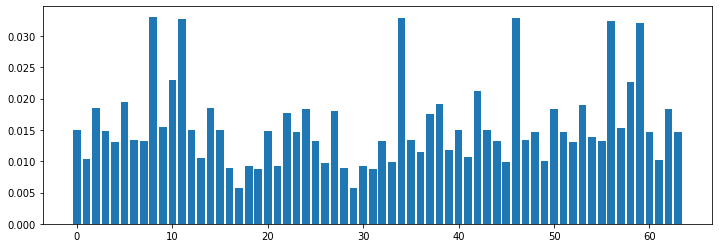

In [26]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
fig, ax = plt.subplots(figsize=(12,4))
ax.bar(x=np.arange(len(np.absolute(state))), height=np.array(np.absolute(state))**2)

<BarContainer object of 64 artists>

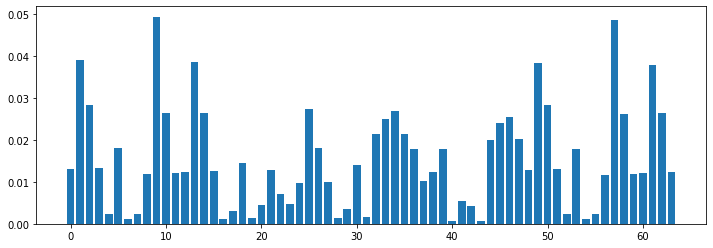

In [25]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
fig, ax = plt.subplots(figsize=(12,4))
ax.bar(x=np.arange(len(res)), height=np.array(res)**2)

plot_histogram([counts_stabilizer, counts_statevector, counts_density, counts_mps],
               title='Counts for different simulation methods',
               legend=['stabilizer', 'statevector',
                       'density_matrix', 'matrix_product_state'])